In [237]:
import warnings
warnings.filterwarnings('ignore')

# Import the SQL datasets

In [238]:
import sqlite3 as sql
import pandas as pd

connection = sql.connect('database.sqlite')

#polarized datasets will only contain reviews having ratings 1,2,4,5

polarisable_data  = pd.read_sql_query('select * from reviews where score!=3 limit 5000',connection)
print('The size of polarisable data is',polarized_data.shape)

The size of polarisable data is (5000, 10)


# Replacing values in Score column in polarisable datasets with positive and negative

In [239]:
scores= polarisable_data['Score']
polarized_scores = scores.map(lambda x: 0 if x<3  else 1)

#polarized_scores.head

polarisable_data['Score'] = polarized_scores
polarized_data=polarisable_data


polarized_data.head()



,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,0,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,1,1350777600,Great taffy,Great taffy at a great price. There was a wid...


# Exploratory Data Analysis

1.The used_id has multiple entries for the sametimestamp, then it shoukd be renoved because it is possible that same entries for the multiple entries at the same timestamp were for the same product and different product id


In [240]:
#dropping data
print(polarized_data.duplicated(['UserId','Time']).sum())


52


In [241]:
deduplicated_data = polarized_data.drop_duplicates(subset={'UserId','Time'},keep='first',inplace=False)
print(deduplicated_data.shape)

(4948, 10)


# Text preproxessing -Removing html and punctuation

In [242]:
print(deduplicated_data.columns)
deduplicated_data['Score']

Index(['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text'],
      dtype='object')


0       1
1       0
2       1
3       0
4       1
5       1
6       1
7       1
8       1
9       1
10      1
11      1
12      0
13      1
14      1
15      1
16      0
17      1
18      1
19      1
20      1
21      1
22      1
23      1
24      1
25      1
26      0
27      1
28      1
30      1
       ..
4968    1
4969    1
4970    0
4971    0
4972    0
4973    0
4974    1
4976    1
4977    1
4978    1
4979    1
4980    1
4981    0
4982    1
4983    1
4984    1
4985    1
4986    1
4987    1
4988    1
4989    1
4990    1
4992    1
4993    1
4994    0
4995    0
4996    1
4997    1
4998    0
4999    0
Name: Score, Length: 4948, dtype: int64

In [243]:
#datasets cleaner

import re

def remove_html(sentences):
    html_tag = re.compile('<.*>?')
    return re.sub(html_tag,' ',sentences)#re.sub is for substitution of the all the html tags in the sentance with ' '

def remove_punctution(sentences):
    cleaned_sentence = re.sub(r'[^a-zA-Z]', r' ',sentences)
    return cleaned_sentence
    




In [244]:
#clean datasets

corpus = deduplicated_data['Text']

cleaned_corpus =[]
for doc in corpus.values:
    cleaned_doc = remove_html(doc)
    cleaned_doc = remove_punctution(cleaned_doc)
    cleaned_corpus.append(cleaned_doc)
    
deduplicated_data['Text']=cleaned_corpus

# Text preprocessing and Removing stop words

In [245]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\RakeshS\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [246]:
print(set(stopwords.words('english')))


{'during', 'when', 'it', 'themselves', 'such', 'after', 'were', 'if', 'couldn', 'your', "needn't", "you'd", 'doesn', "mustn't", 'was', 'until', 'so', 'all', 'now', 'has', 'aren', 'more', 'needn', 'there', 'herself', 'but', 'and', 'do', "you'll", 'own', 'been', 'than', 'no', "wouldn't", "shan't", 'had', "hasn't", 'nor', 'have', 'i', 'they', 'my', 'am', 'didn', 'further', 'did', 'over', 'again', "mightn't", 'out', 've', 'their', 'whom', 's', "that'll", 'hers', 'd', 'hadn', 'most', 'theirs', "you're", 'then', 'the', 'shan', 'an', 'where', 'wouldn', 'ain', 'hasn', 'into', 'in', 'once', 'who', 'weren', 'will', 'ourselves', 'with', 'me', 'are', 'you', 'can', 'a', 'not', 'mustn', 'very', 'why', 'through', 'any', 'his', 'haven', "you've", 'be', 'each', "should've", 'up', 'same', "don't", 'should', 'from', "hadn't", 'while', 'its', 'to', 'm', 'at', 'against', 'above', 'll', 'this', 'below', 'those', 'by', 'him', "she's", 'few', 'off', 'under', 'what', "couldn't", "didn't", 'he', 'y', 'just', 'f

since in stop words also contain not  don't and didn't so we have to add the words to the stop words set

In [247]:
count=0
for doc in deduplicated_data['Text']:
    if 'not' in doc:
        count+=1
print(count)

1536


In [248]:
stopwords = list(stopwords.words('english'))


In [249]:
stopwords_set = set(stopwords)
stopwords_set.remove('not')
print(stopwords_set)

{'during', 'when', 'it', 'themselves', 'such', 'after', 'were', 'if', 'couldn', 'your', "needn't", "you'd", 'doesn', "mustn't", 'was', 'until', 'so', 'all', 'now', 'has', 'aren', 'more', 'needn', 'there', 'herself', 'but', 'and', 'do', "you'll", 'own', 'been', 'than', 'no', "wouldn't", "shan't", 'had', "hasn't", 'nor', 'have', 'i', 'they', 'my', 'am', 'didn', 'further', 'did', 'over', 'again', "mightn't", 'out', 've', 'their', 'whom', 's', "that'll", 'hers', 'd', 'hadn', 'most', 'theirs', "you're", 'then', 'the', 'shan', 'an', 'where', 'wouldn', 'ain', 'hasn', 'into', 'in', 'once', 'who', 'weren', 'will', 'ourselves', 'with', 'me', 'are', 'you', 'can', 'a', 'mustn', 'very', 'why', 'through', 'any', 'his', 'haven', "you've", 'be', 'each', "should've", 'up', 'same', "don't", 'should', 'from', "hadn't", 'while', 'its', 'to', 'm', 'at', 'against', 'above', 'll', 'this', 'below', 'those', 'by', 'him', "she's", 'few', 'off', 'under', 'what', "couldn't", "didn't", 'he', 'y', 'just', 'for', 'r

In [250]:
# lower casing all the in the corpus deduplicated data
lower_cased_docs= [docs.lower() for docs in deduplicated_data['Text']]
deduplicated_data['Text'] = lower_cased_docs

In [251]:
corpus = deduplicated_data['Text']
print(type(corpus))

<class 'pandas.core.series.Series'>


In [252]:
docs_without_stop_words =[]
for i,docs in enumerate(corpus):#enumerate convert the list into object , it can further be used in any iteration
    non_stop_words=[]
    for words in docs.split():
        if words not in stopwords_set:
            non_stop_words.append(words)
            
    docs_without_stop_words.append(','.join(non_stop_words))
            
    

In [253]:
print(docs_without_stop_words[:10])

['bought,several,vitality,canned,dog,food,products,found,good,quality,product,looks,like,stew,processed,meat,smells,better,labrador,finicky,appreciates,product,better', 'product,arrived,labeled,jumbo,salted,peanuts,peanuts,actually,small,sized,unsalted,not,sure,error,vendor,intended,represent,product,jumbo', 'confection,around,centuries,light,pillowy,citrus,gelatin,nuts,case,filberts,cut,tiny,squares,liberally,coated,powdered,sugar,tiny,mouthful,heaven,not,chewy,flavorful,highly,recommend,yummy,treat,familiar,story,c,lewis,lion,witch,wardrobe,treat,seduces,edmund,selling,brother,sisters,witch', 'looking,secret,ingredient,robitussin,believe,found,got,addition,root,beer,extract,ordered,good,made,cherry,soda,flavor,medicinal', 'great,taffy,great,price,wide,assortment,yummy,taffy,delivery,quick,taffy,lover,deal', 'got,wild,hair,taffy,ordered,five,pound,bag,taffy,enjoyable,many,flavors,watermelon,root,beer,melon,peppermint,grape,etc,complaint,bit,much,red,black,licorice,flavored,pieces,not,

# Text preprocessing: Stemming

In [254]:
from nltk.stem import SnowballStemmer

In [255]:
stemmer = SnowballStemmer('english')

stemmer.stem('foundation')


'foundat'

In [256]:
stemmed_corpus=[]
for doc in docs_without_stop_words:
    stemmed_words = []
    for words in doc.split():
        stemmed_words.append(stemmer.stem(words))
    
    stemmed_doc = ' '.join(stemmed_words)
    stemmed_corpus.append(stemmed_doc)

In [257]:
print(stemmed_corpus[:10])

['bought,several,vitality,canned,dog,food,products,found,good,quality,product,looks,like,stew,processed,meat,smells,better,labrador,finicky,appreciates,product,bett', 'product,arrived,labeled,jumbo,salted,peanuts,peanuts,actually,small,sized,unsalted,not,sure,error,vendor,intended,represent,product,jumbo', 'confection,around,centuries,light,pillowy,citrus,gelatin,nuts,case,filberts,cut,tiny,squares,liberally,coated,powdered,sugar,tiny,mouthful,heaven,not,chewy,flavorful,highly,recommend,yummy,treat,familiar,story,c,lewis,lion,witch,wardrobe,treat,seduces,edmund,selling,brother,sisters,witch', 'looking,secret,ingredient,robitussin,believe,found,got,addition,root,beer,extract,ordered,good,made,cherry,soda,flavor,medicin', 'great,taffy,great,price,wide,assortment,yummy,taffy,delivery,quick,taffy,lover,d', 'got,wild,hair,taffy,ordered,five,pound,bag,taffy,enjoyable,many,flavors,watermelon,root,beer,melon,peppermint,grape,etc,complaint,bit,much,red,black,licorice,flavored,pieces,not,particu

# Bags of Words

Simple vector representation of docs in the corpus

In [258]:
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer

In [259]:
count_vectorizer = CountVectorizer()

vector_of_words = count_vectorizer.fit_transform(np.array(stemmed_corpus))

In [260]:
type(vector_of_words)

scipy.sparse.csr.csr_matrix

In [261]:
print(vector_of_words)

  (0, 854)	1
  (0, 437)	1
  (0, 3717)	1
  (0, 5350)	1
  (0, 855)	1
  (0, 8946)	1
  (0, 5958)	1
  (0, 7494)	1
  (0, 9337)	1
  (0, 5544)	1
  (0, 5654)	1
  (0, 7508)	2
  (0, 7677)	1
  (0, 4195)	1
  (0, 3905)	1
  (0, 7513)	1
  (0, 3851)	1
  (0, 2905)	1
  (0, 1351)	1
  (0, 10654)	1
  (0, 8674)	1
  (0, 1035)	1
  (1, 8047)	1
  (1, 5023)	1
  (1, 10561)	1
  :	:
  (4947, 6672)	2
  (4947, 10878)	1
  (4947, 8609)	1
  (4947, 8635)	1
  (4947, 8943)	2
  (4947, 6851)	1
  (4947, 1049)	3
  (4947, 4455)	1
  (4947, 2184)	1
  (4947, 3360)	1
  (4947, 7828)	1
  (4947, 9038)	1
  (4947, 479)	1
  (4947, 4092)	1
  (4947, 10013)	1
  (4947, 8742)	1
  (4947, 5691)	1
  (4947, 10807)	1
  (4947, 3704)	1
  (4947, 277)	1
  (4947, 10827)	1
  (4947, 6701)	2
  (4947, 822)	1
  (4947, 6497)	1
  (4947, 3851)	1


# T-sne plot for simple vector model matrix for our corpus

In [262]:
from sklearn.manifold import TSNE

In [263]:
vector_of_words_subset = vector_of_words[:2000]

In [264]:
vector_of_words.shape

(4948, 11120)

In [265]:
vector_of_words_subset.shape

(2000, 11120)

In [266]:
t_sne = TSNE(n_components=2,random_state =0,perplexity=50)

In [267]:
dim_reduced_corpus = t_sne.fit_transform(vector_of_words_subset.todense())

In [268]:
type(dim_reduced_corpus)

numpy.ndarray

In [269]:
dim_reduced_corpus.shape
print(dim_reduced_corpus)

[[-0.04599534  1.5155158 ]
 [-0.2042149   1.5456129 ]
 [-1.4999825   0.91340715]
 ...
 [ 0.32678404  0.03054842]
 [-0.7909856   0.68611866]
 [-2.005987    0.34941098]]


In [270]:
label = deduplicated_data['Score'].head(2000)
print(label)

0       1
1       0
2       1
3       0
4       1
5       1
6       1
7       1
8       1
9       1
10      1
11      1
12      0
13      1
14      1
15      1
16      0
17      1
18      1
19      1
20      1
21      1
22      1
23      1
24      1
25      1
26      0
27      1
28      1
30      1
       ..
1988    1
1989    0
1990    0
1991    1
1992    1
1993    1
1994    1
1995    1
1996    1
1997    1
1998    0
1999    1
2000    1
2001    1
2002    1
2003    0
2004    1
2005    0
2006    1
2007    0
2008    1
2009    1
2010    1
2011    0
2012    1
2013    1
2014    1
2015    1
2016    1
2017    1
Name: Score, Length: 2000, dtype: int64


In [271]:
label = np.array(label)
label.shape

(2000,)

In [272]:
label1=label.reshape(2000,1)
print(label1.shape)

(2000, 1)


In [273]:
dim_reduced_corpus_label = np.concatenate((dim_reduced_corpus,label1),axis = 1)
print(dim_reduced_corpus_label)

[[-0.04599534  1.5155158   1.        ]
 [-0.2042149   1.54561293  0.        ]
 [-1.49998248  0.91340715  1.        ]
 ...
 [ 0.32678404  0.03054842  1.        ]
 [-0.79098558  0.68611866  1.        ]
 [-2.00598693  0.34941098  1.        ]]


In [274]:
dim_reduced_corpus_label_df = pd.DataFrame(dim_reduced_corpus_label,columns=('Dim1','Dim2','Label'))

In [275]:
import seaborn as sns
import matplotlib.pyplot as plt

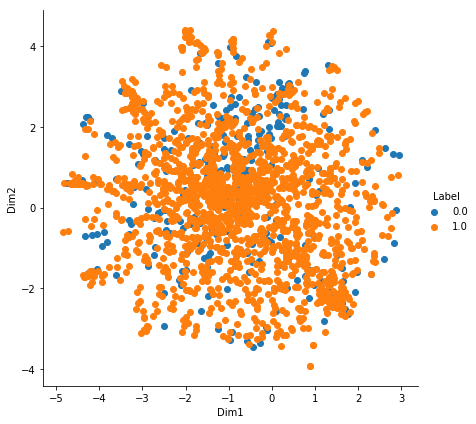

In [276]:
sns.FacetGrid(dim_reduced_corpus_label_df, hue = 'Label', size = 6)\
    .map(plt.scatter, 'Dim1', 'Dim2')\
    .add_legend()

plt.show()

# T-sne plot for Tf-Idf

In [277]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [278]:
tfidf_vectorizer = TfidfVectorizer()

In [279]:
vector_of_words = tfidf_vectorizer.fit_transform(stemmed_corpus)

In [280]:
vector_of_words_subset = vector_of_words[:2000]

In [281]:
type(vector_of_words)

scipy.sparse.csr.csr_matrix

In [282]:

vector_of_words_subset.shape

(2000, 11120)

In [283]:
vector_of_words_subset_dense = vector_of_words_subset.todense()

In [284]:

type(vector_of_words_subset_dense)

numpy.matrixlib.defmatrix.matrix

In [285]:
dimension_reduced_corpus_2000 = t_sne.fit_transform(vector_of_words_subset_dense)

In [286]:
dimension_reduced_corpus_2000.shape

(2000, 2)

In [287]:
print(label1.shape)

(2000, 1)


In [288]:
dimesion_reduced_corpus_labels_2000 = np.concatenate((dimension_reduced_corpus_2000, label1), axis = 1)
print(dimesion_reduced_corpus_labels_2000.shape)

(2000, 3)


# The todense() method seems to be doing something very "dense" (significant), somethign difficult to comprehend, but all it does is, converts the sparse matrix representation to a numpy matrix representation.

In [289]:
dimension_reduced_corpus_labels_2000_df =pd.DataFrame(dimesion_reduced_corpus_labels_2000, columns = ('Dim1', 'Dim2', 'Label'))

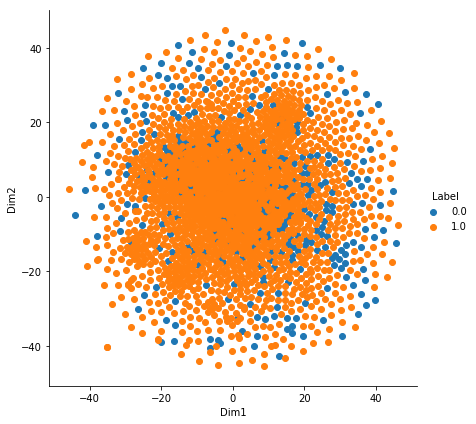

In [290]:
sns.FacetGrid(dimension_reduced_corpus_labels_2000_df, hue = 'Label', size = 6)\
    .map(plt.scatter, 'Dim1', 'Dim2')\
    .add_legend()

plt.show()

# TSNE average W2V

unlike CountVectorizer, or tfidf vectorizer, the word2vec model requires each sentence in the corpus to be a list of words, rather than one complete string of sentence

In [291]:
deduplicated_data.columns

Index(['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text'],
      dtype='object')

In [298]:
list_of_tokenized_sentences = [] # each sentence is converted into a list of words, and list_of_tokenized_sentences
                                # stores the list of all these list of words
count = 0
labels_2000 = []
for index, sentence in enumerate(stemmed_corpus[:2008]): # 8 sentences in stemmed_corpus are empty
    if(len(sentence) == 0):
        continue
    
    # using iloc because loc helps retrieving rows and columns by labels (row label and column label, not indices) \
    # the labels in the rows are not continuous, for eg, row label 29 is missing. this was causing error. \
    # iloc on the other hand, uses integer position (indices) to access rows and columns, as in case of normal \
    # arrays.
    labels_2000.append(deduplicated_data.iloc[index, 6]) # 'Score' index position = 6
    list_of_tokenized_sentences.append(sentence.split())
    
print(list_of_tokenized_sentences)

[['bought,several,vitality,canned,dog,food,products,found,good,quality,product,looks,like,stew,processed,meat,smells,better,labrador,finicky,appreciates,product,bett'], ['product,arrived,labeled,jumbo,salted,peanuts,peanuts,actually,small,sized,unsalted,not,sure,error,vendor,intended,represent,product,jumbo'], ['confection,around,centuries,light,pillowy,citrus,gelatin,nuts,case,filberts,cut,tiny,squares,liberally,coated,powdered,sugar,tiny,mouthful,heaven,not,chewy,flavorful,highly,recommend,yummy,treat,familiar,story,c,lewis,lion,witch,wardrobe,treat,seduces,edmund,selling,brother,sisters,witch'], ['looking,secret,ingredient,robitussin,believe,found,got,addition,root,beer,extract,ordered,good,made,cherry,soda,flavor,medicin'], ['great,taffy,great,price,wide,assortment,yummy,taffy,delivery,quick,taffy,lover,d'], ['got,wild,hair,taffy,ordered,five,pound,bag,taffy,enjoyable,many,flavors,watermelon,root,beer,melon,peppermint,grape,etc,complaint,bit,much,red,black,licorice,flavored,pieces,

In [293]:
print(list_of_tokenized_sentences[:5])
len(list_of_tokenized_sentences)

[['bought,several,vitality,canned,dog,food,products,found,good,quality,product,looks,like,stew,processed,meat,smells,better,labrador,finicky,appreciates,product,bett'], ['product,arrived,labeled,jumbo,salted,peanuts,peanuts,actually,small,sized,unsalted,not,sure,error,vendor,intended,represent,product,jumbo'], ['confection,around,centuries,light,pillowy,citrus,gelatin,nuts,case,filberts,cut,tiny,squares,liberally,coated,powdered,sugar,tiny,mouthful,heaven,not,chewy,flavorful,highly,recommend,yummy,treat,familiar,story,c,lewis,lion,witch,wardrobe,treat,seduces,edmund,selling,brother,sisters,witch'], ['looking,secret,ingredient,robitussin,believe,found,got,addition,root,beer,extract,ordered,good,made,cherry,soda,flavor,medicin'], ['great,taffy,great,price,wide,assortment,yummy,taffy,delivery,quick,taffy,lover,d']]


2000

In [294]:
import gensim

In [295]:

# since a small subset of corpus is being used, we take min_count = 1, otherwise some words get skipped\
# (eg- 'vital' got skipped when min_count was set at its default value of 5)
w2v_model = gensim.models.Word2Vec(list_of_tokenized_sentences, min_count = 1, size = 50, workers = 4)

In [300]:
w2v_model.wv['bought,several,vitality,canned,dog,food,products,found,good,quality,product,looks,like,stew,processed,meat,smells,better,labrador,finicky,appreciates,product,bett']

array([-5.3870506e-03, -5.7099764e-03, -8.5246023e-03, -3.7845953e-03,
       -2.8945713e-03,  8.5206627e-04, -8.3086351e-03,  9.9708152e-04,
       -3.9610076e-03, -9.0155359e-03,  1.4159754e-04,  8.7272441e-03,
        2.0057375e-03,  9.2578419e-03,  1.4171866e-03,  5.1503778e-03,
       -8.3265984e-03, -1.0446403e-04,  5.1272097e-03, -2.0819264e-03,
       -8.7607047e-03,  1.9242369e-03, -9.5111057e-03,  8.5823257e-03,
        6.1446871e-03,  2.0893868e-03,  5.8116917e-03,  3.9159777e-03,
        6.1848150e-05,  2.4676998e-03,  5.6168181e-03,  7.0123579e-03,
        8.3306828e-04, -1.5536521e-03,  1.4902321e-03, -4.8675220e-03,
        6.3626692e-03,  7.8988299e-03,  3.5208450e-03, -4.0794527e-03,
       -4.3225246e-03, -8.4289843e-03,  1.6952343e-03,  8.7317014e-03,
        9.7514922e-03,  5.5400920e-03, -4.7255051e-03, -7.8977654e-03,
        9.0773683e-03, -1.7312549e-03], dtype=float32)

In [301]:
import os

if(not os.path.exists('w2v_practice.model')):
    w2v_model.save('w2v_practice.model')
    
else:
    w2v_model = gensim.models.Word2Vec.load('w2v_practice.model')

In [302]:
vocab = w2v_model.wv.vocab

In [303]:
print(type(vocab))

<class 'dict'>


In [304]:
vocab['vitality']

KeyError: 'vitality'

In [ ]:
avg_w2v = []
for tokenized_sentence in list_of_tokenized_sentences:
    sum_of_word_vectors = 0
    for word in tokenized_sentence:
        sum_of_word_vectors += w2v_model.wv[word]
    avg_w2v.append(sum_of_word_vectors/len(tokenized_sentence))

In [305]:
avg_w2v = np.array(avg_w2v)

In [306]:
len(avg_w2v)

2000

In [307]:
avg_w2v = np.array(avg_w2v)

In [308]:
avg_w2v[0]

array([-5.3870506e-03, -5.7099764e-03, -8.5246023e-03, -3.7845953e-03,
       -2.8945713e-03,  8.5206627e-04, -8.3086351e-03,  9.9708152e-04,
       -3.9610076e-03, -9.0155359e-03,  1.4159754e-04,  8.7272441e-03,
        2.0057375e-03,  9.2578419e-03,  1.4171866e-03,  5.1503778e-03,
       -8.3265984e-03, -1.0446403e-04,  5.1272097e-03, -2.0819264e-03,
       -8.7607047e-03,  1.9242369e-03, -9.5111057e-03,  8.5823257e-03,
        6.1446871e-03,  2.0893868e-03,  5.8116917e-03,  3.9159777e-03,
        6.1848150e-05,  2.4676998e-03,  5.6168181e-03,  7.0123579e-03,
        8.3306828e-04, -1.5536521e-03,  1.4902321e-03, -4.8675220e-03,
        6.3626692e-03,  7.8988299e-03,  3.5208450e-03, -4.0794527e-03,
       -4.3225246e-03, -8.4289843e-03,  1.6952343e-03,  8.7317014e-03,
        9.7514922e-03,  5.5400920e-03, -4.7255051e-03, -7.8977654e-03,
        9.0773683e-03, -1.7312549e-03], dtype=float32)

In [309]:
dim_reduced_avg_w2v = t_sne.fit_transform(avg_w2v)

In [310]:
labels_2000 = np.array(labels_2000).reshape(2000,1)

In [311]:
dim_reduced_avg_w2v_with_labels = np.concatenate((dim_reduced_avg_w2v, labels_2000), axis = 1)

In [312]:
dim_reduced_avg_w2v_df = pd.DataFrame(dim_reduced_avg_w2v_with_labels, columns = ['Dim1', 'Dim2', 'Label'])

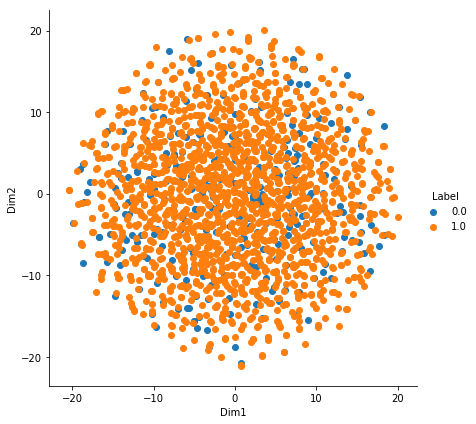

In [313]:
sns.FacetGrid(dim_reduced_avg_w2v_df, hue = 'Label', size = 6)\
            .map(plt.scatter, 'Dim1', 'Dim2')\
            .add_legend()